In [1]:
import csv
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_trials = 5



In [2]:
model_name = "skm-cv"
model_dir = os.path.join(models_dir, model_name)


skm_fns = np.zeros((n_trials, n_units))
skm_fps = np.zeros((n_trials, n_units))
skm_tns = np.zeros((n_trials, n_units))
skm_tps = np.zeros((n_trials, n_units))


# Loop over trials.
for trial_id in range(n_trials):

    
    # Loop over units.
    for test_unit_id, test_unit_str in enumerate(units):

        # Define path to predictions.
        unit_dir = os.path.join(model_dir, test_unit_str)
        trial_str = "trial-" + str(5 + trial_id)
        trial_dir = os.path.join(unit_dir, trial_str)
        predictions_name = "_".join([
            dataset_name,
            "skm-proba",
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "clip-predictions.csv"
        ])
        predictions_path = os.path.join(trial_dir, predictions_name)

        # Remove header, which has too few columns (hack).
        with open(predictions_path, 'r') as f:
            reader = csv.reader(f)
            rows = list(reader)
        rows = [",".join(row) for row in rows]
        rows = rows[1:]
        rows = "\n".join(rows)

        # Parse rows with correct header.
        df = pd.read_csv(StringIO(rows),
            names=[
                "Dataset",
                "Test unit",
                "Prediction unit",
                "Timestamp",
                "Center Freq (Hz)",
                "Augmentation",
                "Key",
                "Ground truth",
                "Predicted probability"])
        
        # Extract y_pred and y_true.
        y_pred = np.array((df["Predicted probability"] > 0.5)).astype("int")
        y_true = np.array(df["Ground truth"])

        # Compute confusion matrix.
        test_tn, test_fp, test_fn, test_tp =\
            sklearn.metrics.confusion_matrix(
                y_true, y_pred).ravel()
            
        skm_fns[trial_id, test_unit_id] = test_fn
        skm_fps[trial_id, test_unit_id] = test_fp
        skm_tns[trial_id, test_unit_id] = test_tn
        skm_tps[trial_id, test_unit_id] = test_tp
            
        

In [3]:
skm_accs = (skm_tp)

array([[ 2926.,  3254.,  7831.,  4845.,  6288.,  6355.],
       [ 2926.,  3261.,  7913.,  4808.,  6331.,  6344.],
       [ 2926.,  3090.,  7772.,  4837.,  6255.,  6276.],
       [ 2926.,  3257.,  7891.,  4864.,  6242.,  6231.],
       [ 2926.,  3478.,  7784.,  4839.,  6291.,  6454.]])

In [71]:
skm_fns

range(10, 6)

In [ ]:
report = {}

for aug_kind_str in ["none", "all"]:

    # Define model directory
    model_name = "icassp-convnet"
    if not aug_kind_str == "none":
        model_name = "_".join([model_name, "aug-" + aug_kind_str])
    model_dir = os.path.join(models_dir, model_name)


    # Initialize dictionaries
    aug_report = {
        "validation": {},
        "test_cv-acc_th=0.5": {}
    }

    # Initialize matrix of validation accuracies.
    val_accs = np.zeros((n_units, n_trials))
    val_tps = np.zeros((n_units, n_trials))
    val_tns = np.zeros((n_units, n_trials))
    val_fps = np.zeros((n_units, n_trials))
    val_fns = np.zeros((n_units, n_trials))
    
    test_accs = np.zeros((n_units, n_trials))
    test_tps = np.zeros((n_units, n_trials))
    test_tns = np.zeros((n_units, n_trials))
    test_fps = np.zeros((n_units, n_trials))
    test_fns = np.zeros((n_units, n_trials))


    # Loop over test units.
    for test_unit_id, test_unit_str in enumerate(units):


        # Define directory for test unit.
        test_unit_dir = os.path.join(model_dir, test_unit_str)


        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]


        # Loop over trials.
        for trial_id in range(n_trials):


            # Define directory for trial.
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)


            # Initialize.
            break_switch = False
            val_fn = 0
            val_fp = 0
            val_tn = 0
            val_tp = 0


            # Loop over validation units.
            for val_unit_str in validation_units:

                predictions_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    "trial-" + str(trial_id),
                    "predict-" + val_unit_str,
                    "clip-predictions.csv"
                ])
                prediction_path = os.path.join(
                    trial_dir, predictions_name)

                # Load prediction.
                csv_file = pd.read_csv(prediction_path)
                y_pred = np.array(csv_file["Predicted probability"])
                y_pred = (y_pred > 0.5).astype('int')

                # Check that CSV file is not corrupted.
                if len(y_pred) == 0:
                    break_switch = True
                    break

                # Load ground truth.
                y_true = np.array(csv_file["Ground truth"])

                # Compute confusion matrix.
                tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
                    y_true, y_pred).ravel()

                val_fn = val_fn + fn
                val_fp = val_fp + fp
                val_tn = val_tn + tn
                val_tp = val_tp + tp


            if not break_switch:
                val_acc = (val_tn+val_tp) / (val_fn+val_fp+val_tn+val_tp)
            else:
                val_fn = 0
                val_fp = 0
                val_tn = 0
                val_tp = 0
                val_acc = 0.0
            
            val_fns[test_unit_id, trial_id] = val_fn
            val_fps[test_unit_id, trial_id] = val_fp
            val_tns[test_unit_id, trial_id] = val_tn
            val_tps[test_unit_id, trial_id] = val_tp
            val_accs[test_unit_id, trial_id] = val_acc


            # Initialize.

            predictions_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                "trial-" + str(trial_id),
                "predict-" + test_unit_str,
                "clip-predictions.csv"
            ])
            prediction_path = os.path.join(
                trial_dir, predictions_name)

            # Load prediction.
            csv_file = pd.read_csv(prediction_path)
            y_pred = np.array(csv_file["Predicted probability"])
            y_pred = (y_pred > 0.5).astype('int')


            # Check that CSV file is not corrupted.
            if len(y_pred) == 0:
                test_tn, test_fp, test_fn, test_tp = 0, 0, 0, 0
                test_acc = 0.0
            else:
                # Load ground truth.
                y_true = np.array(csv_file["Ground truth"])
                # Compute confusion matrix.
                test_tn, test_fp, test_fn, test_tp =\
                    sklearn.metrics.confusion_matrix(
                        y_true, y_pred).ravel()
                test_acc = (test_tn+test_tp) / (test_fn+test_fp+test_tn+test_tp)

            test_fns[test_unit_id, trial_id] = test_fn
            test_fps[test_unit_id, trial_id] = test_fp
            test_tns[test_unit_id, trial_id] = test_tn
            test_tps[test_unit_id, trial_id] = test_tp
            test_accs[test_unit_id, trial_id] = test_acc 
            
    aug_report["validation"]["FN"] = test_fn
    aug_report["validation"]["FP"] = test_fp
    aug_report["validation"]["TN"] = test_tn
    aug_report["validation"]["TP"] = test_tp
    aug_report["validation"]["accuracy"] = val_accs
    
    best_trials = np.argsort(aug_report["validation"]["accuracy"], axis=1)
    aug_report["validation"]["best_trials"] = best_trials
    
    aug_report["test_cv-acc_th=0.5"]["FN"] = test_fns
    aug_report["test_cv-acc_th=0.5"]["FP"] = test_fps
    aug_report["test_cv-acc_th=0.5"]["TN"] = test_tns
    aug_report["test_cv-acc_th=0.5"]["TP"] = test_tps
    aug_report["test_cv-acc_th=0.5"]["accuracy"] = test_accs

    
    cv_accs = []
    for eval_trial_id in range(5):
        cv_fn = 0
        cv_fp = 0
        cv_tn = 0
        cv_tp = 0

        for test_unit_id, test_unit_str in enumerate(units):

            best_trials = aug_report["validation"]["best_trials"]
            unit_best_trials = best_trials[test_unit_id, -5:]
            unit_best_trials = sorted(unit_best_trials)
            trial_id = unit_best_trials[eval_trial_id]

            cv_fn = cv_fn + aug_report["test_cv-acc_th=0.5"]["FN"][test_unit_id, trial_id]
            cv_fp = cv_fp + aug_report["test_cv-acc_th=0.5"]["FP"][test_unit_id, trial_id]
            cv_tn = cv_tn + aug_report["test_cv-acc_th=0.5"]["TN"][test_unit_id, trial_id]
            cv_tp = cv_tp + aug_report["test_cv-acc_th=0.5"]["TP"][test_unit_id, trial_id]

        cv_acc = (cv_tn+cv_tp) / (cv_tn+cv_tp+cv_fn+cv_fp)
        cv_accs.append(cv_acc)

        
    aug_report["test_cv-acc_th=0.5"]["global_acc"] = np.array(cv_accs)
    
    
    report[aug_kind_str] = aug_report

In [18]:
none_accs = report["none"]['test_cv-acc_th=0.5']['global_acc']
print("      acc = {:5.2f}% ± {:3.1f}".format(100*np.mean(none_accs), 100*np.std(none_accs)))

all_accs = report["all"]['test_cv-acc_th=0.5']['global_acc']
print("[AUG] acc = {:5.2f}% ± {:3.1f}".format(100*np.mean(all_accs), 100*np.std(all_accs)))

      acc = 90.48% ± 1.5
[AUG] acc = 94.85% ± 0.8


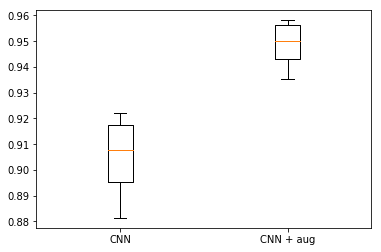

In [31]:
#plt.figure(figsize=(9,6))
plt.boxplot([none_accs, all_accs], labels=["CNN", "CNN + aug"]);

In [25]:
1e-3

0.001